In [4]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import scipy.optimize as opt
from scipy.stats import linregress
from scipy.stats.mstats import theilslopes
from scipy.signal import fftconvolve

from astropy import units as u
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import vstack, hstack, Table, Column
from astropy.coordinates import SkyCoord, match_coordinates_sky

from photutils import DAOStarFinder

import simcado as sim
from simcado.sandbox import imf

## New code for generating images with SimCADO

So the plan is to do this for the arches cluster Arches cluster and the ONC in the LMC and for Ori 1b in NGC300

Change 

In [2]:
b = 24.5
10**(1+b/5)
np.logspace(2,4,21)
n=26
bins = np.logspace(-3, 2, n)

i = np.where(bins > 1)[0][0]
i, bins
np.arange(15.5,28,3)

d = np.array([8.5E3, 50E3, 200E3, 800E3, 2.1E6, 5E6])
5*np.log10(d)-5

str([1,2,3])

'[1, 2, 3]'

Cluster mass:  4799.82806147
star_density 3000.0 dist 50000.0 mass 3000.0


C:\Program Files\Anaconda3\lib\site-packages\simcado\commands.py:417: UserWarning: Keyword FPA_CHIP_LAYOUT path doesn't exist: 
                #  id    x_cen    y_cen   x_len   y_len   angle    gain
                #        arcsec   arcsec   pixel  pixel     deg  e-/ADU
                    0        0        0    500  500   0.0     1.0
                
  warnings.warn("Keyword "+key+" path doesn't exist: "+fname)


Generating image for chip 0
Reading out chip 0 using superfast


C:\Program Files\Anaconda3\lib\site-packages\simcado\detector.py:397: UserWarning: ValueError - Couldn't add keyword: FPA_CHIP_LAYOUT
  warnings.warn("ValueError - Couldn't add keyword: "+key)
C:\Program Files\Anaconda3\lib\site-packages\simcado\sandbox\imf.py:92: UserWarning: Warning: converting a masked element to nan.
  m_stats = np.array(m_stats)


Cluster mass:  4799.05702855
star_density 3000.0 dist 50000.0 mass 3000.0
Generating image for chip 0
Reading out chip 0 using superfast
Cluster mass:  4799.90683988
star_density 3000.0 dist 50000.0 mass 3000.0
Generating image for chip 0
Reading out chip 0 using superfast
Cluster mass:  4799.97164365
star_density 3000.0 dist 50000.0 mass 3000.0
Generating image for chip 0
Reading out chip 0 using superfast
Cluster mass:  4775.52584642
star_density 3000.0 dist 50000.0 mass 3000.0
Generating image for chip 0
Reading out chip 0 using superfast
Cluster mass:  4799.81093571
star_density 3000.0 dist 50000.0 mass 3000.0
Generating image for chip 0
Reading out chip 0 using superfast


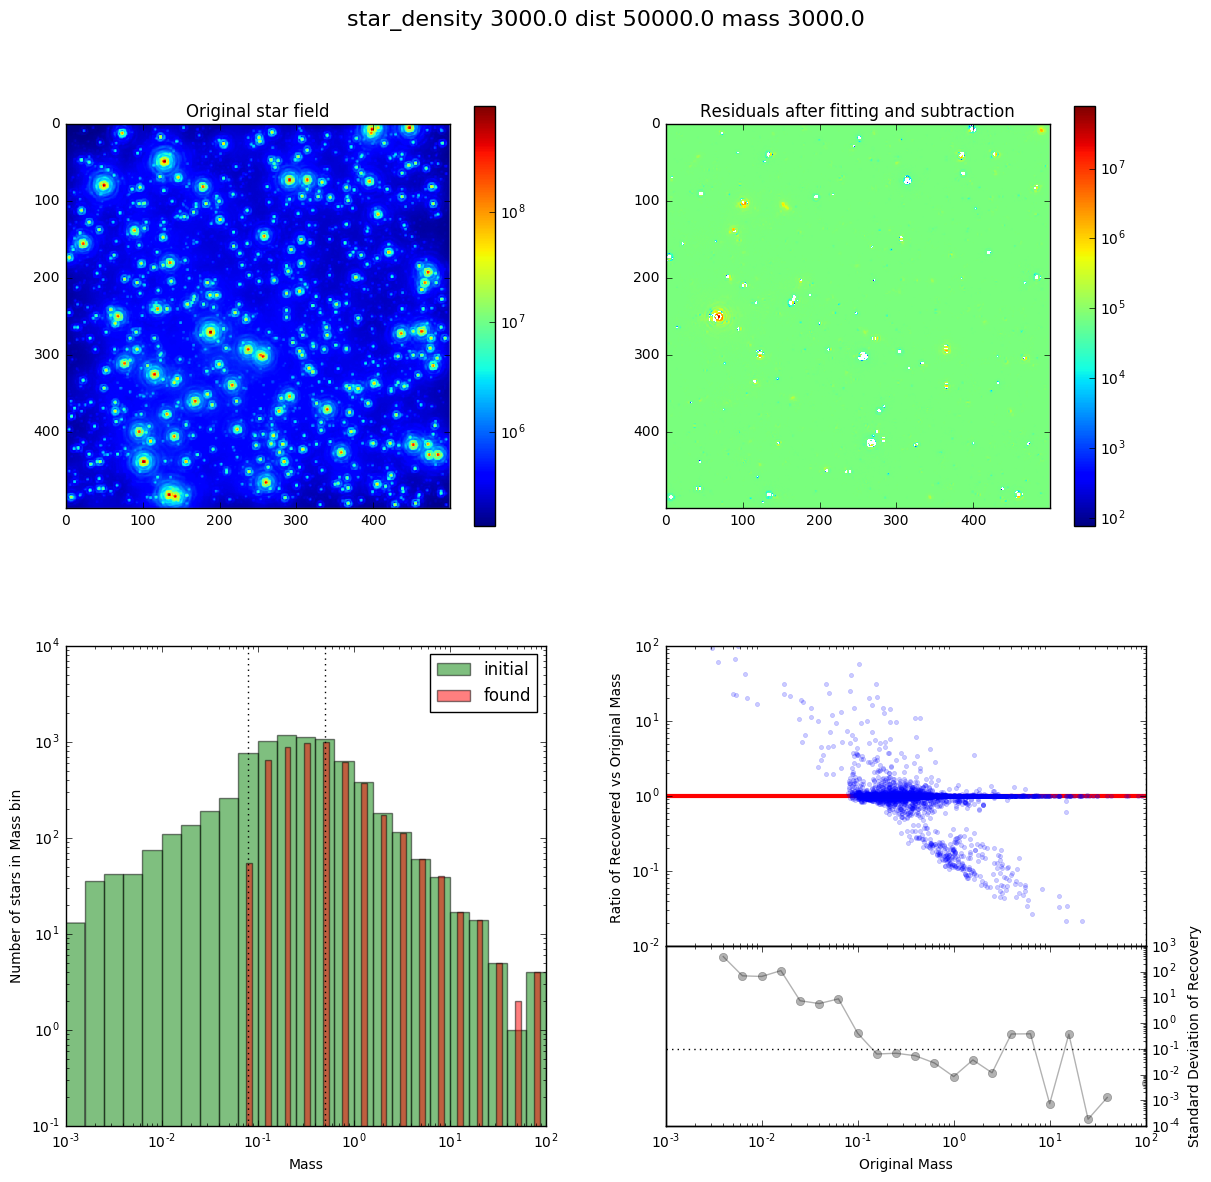

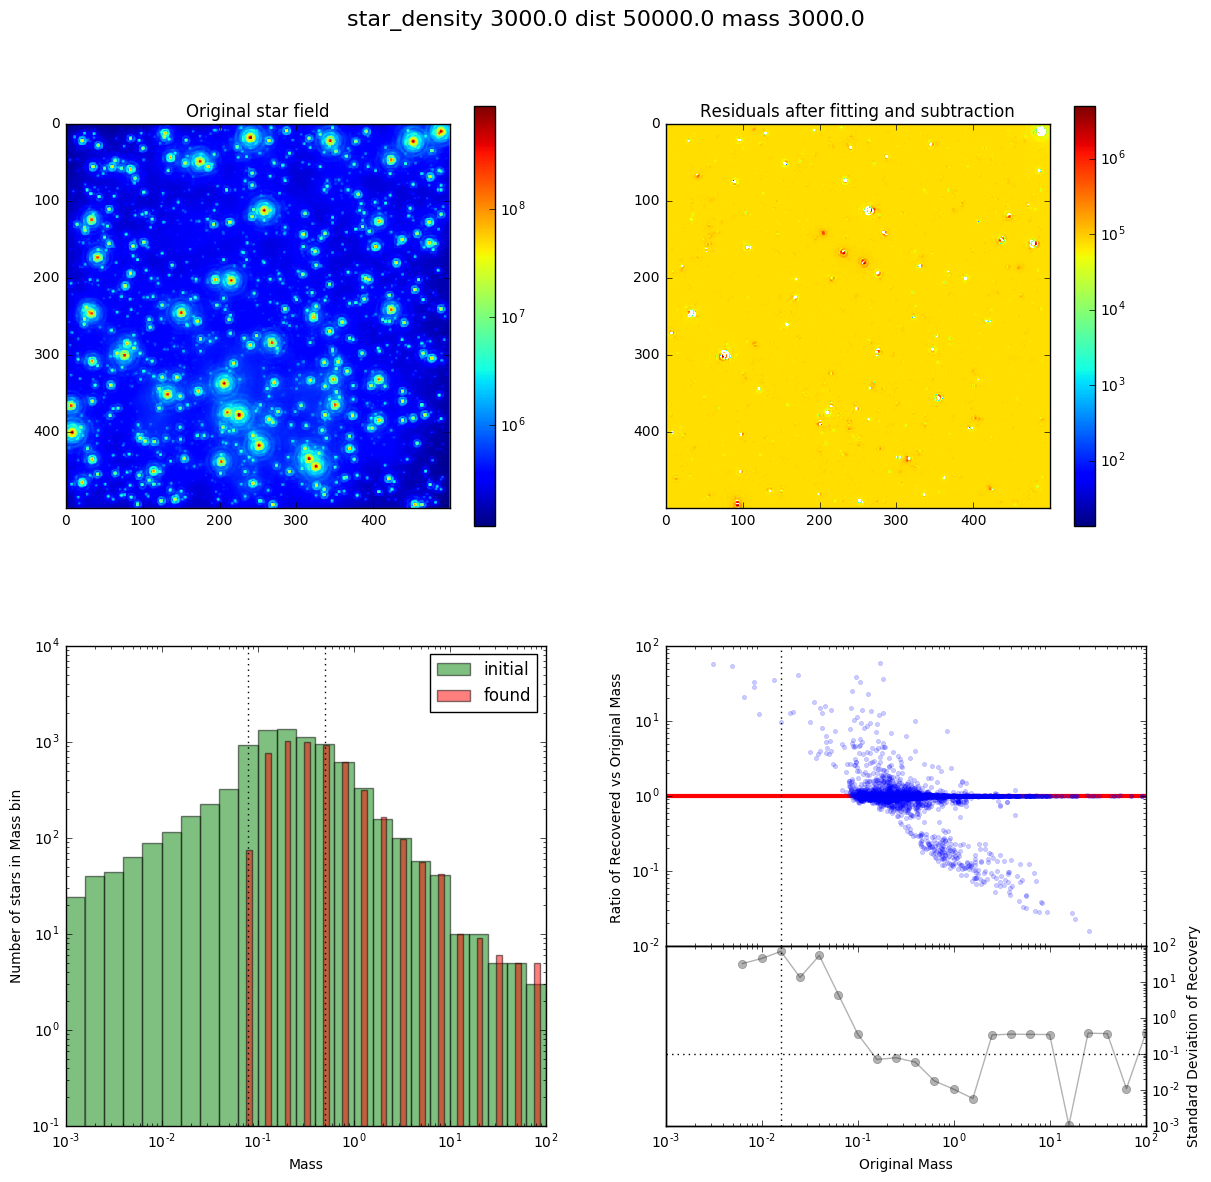

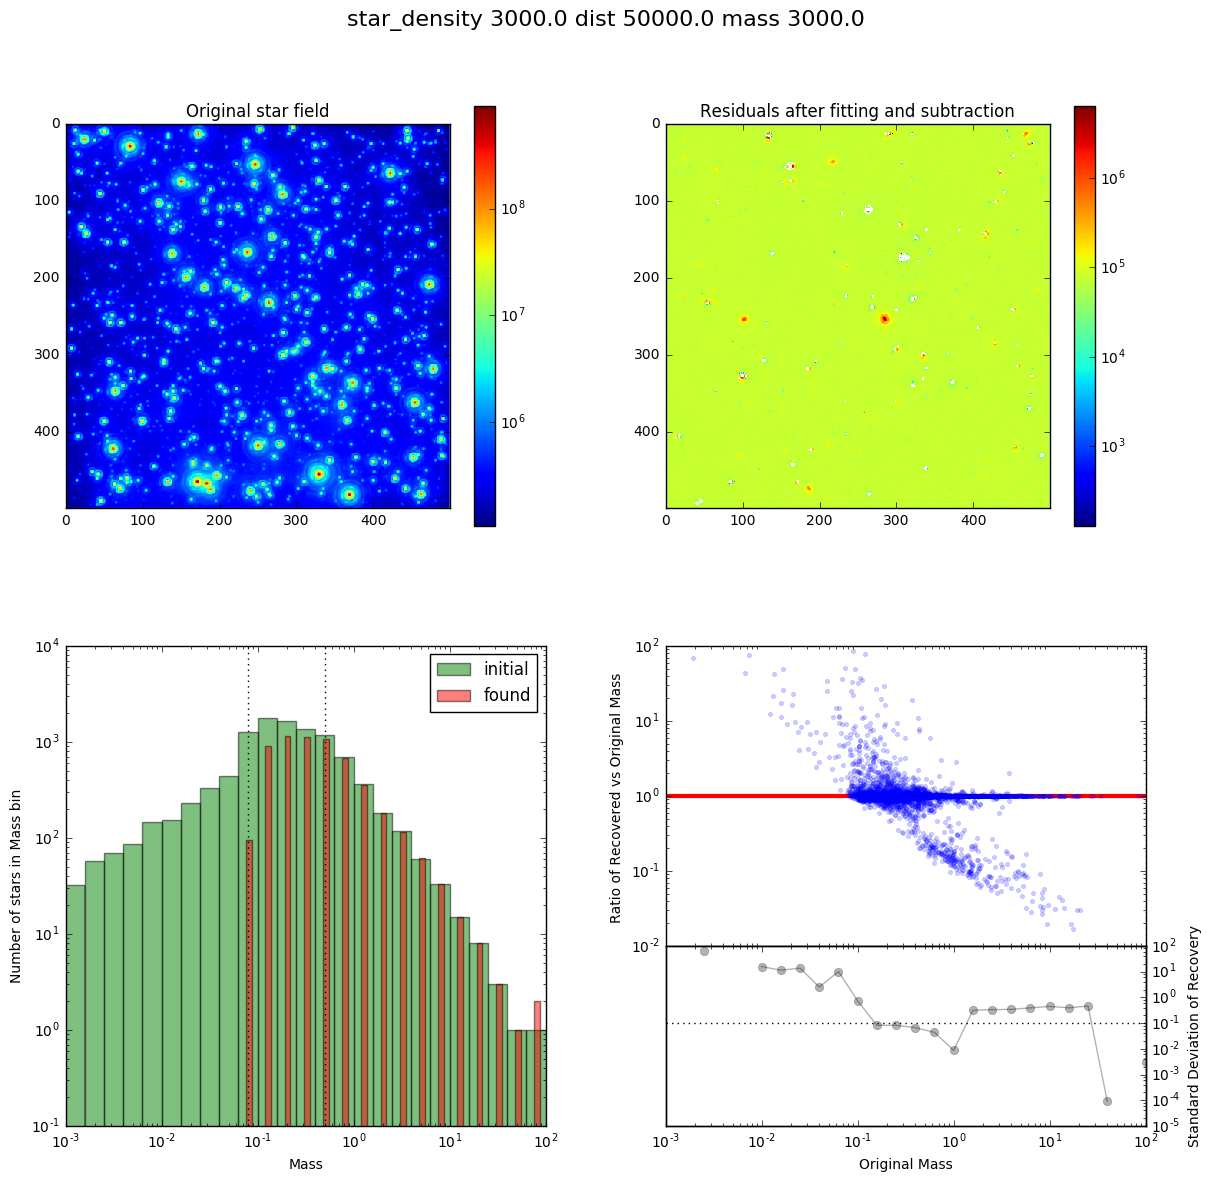

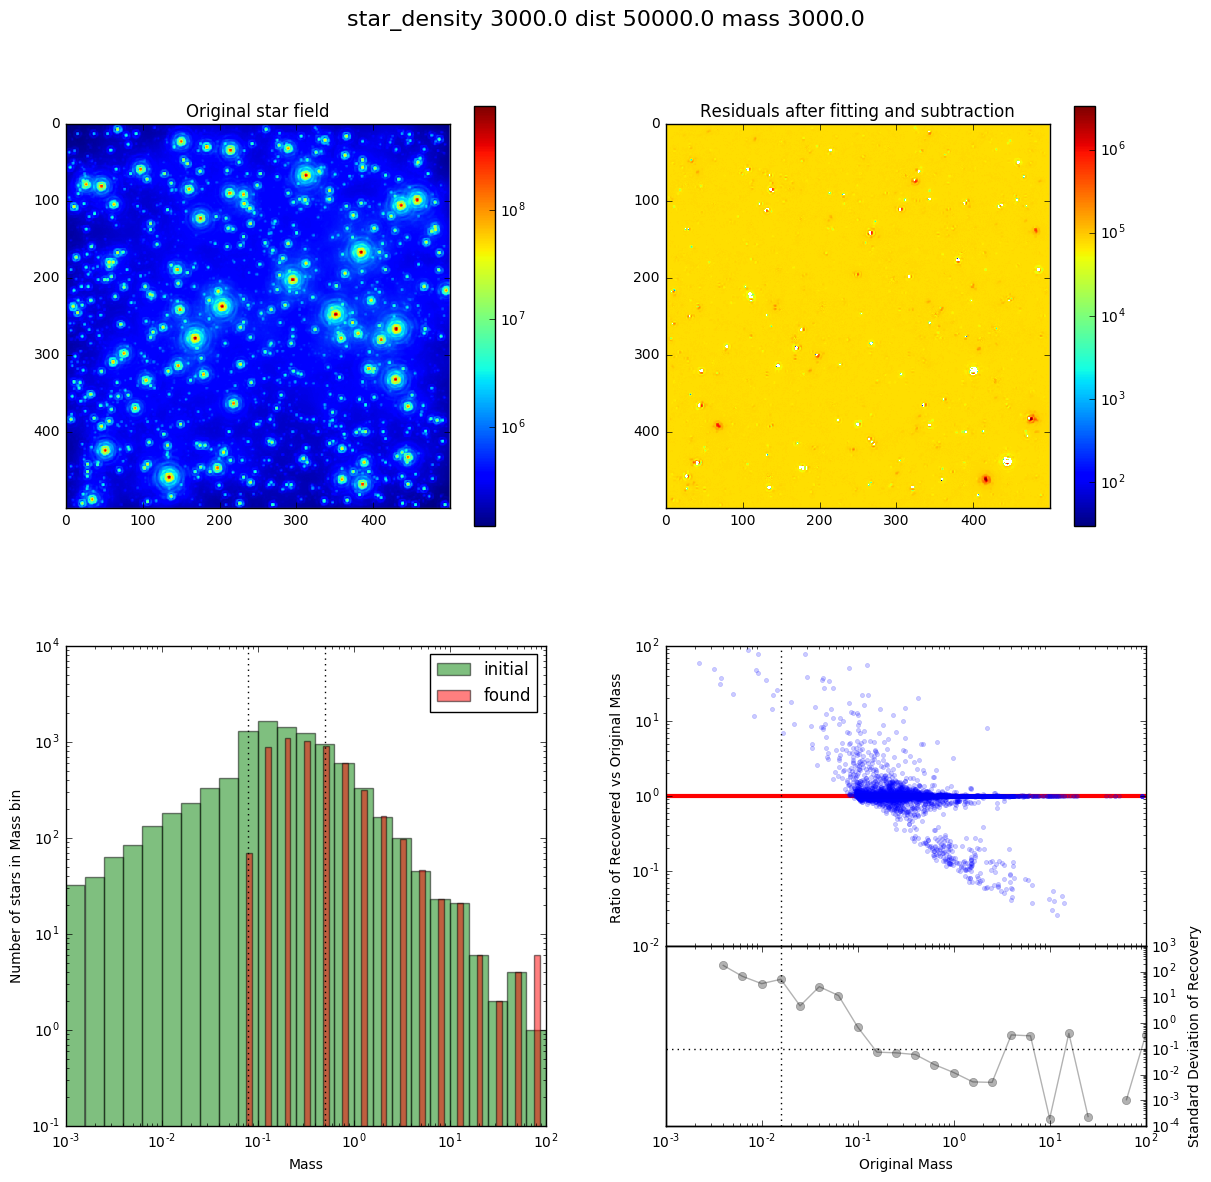

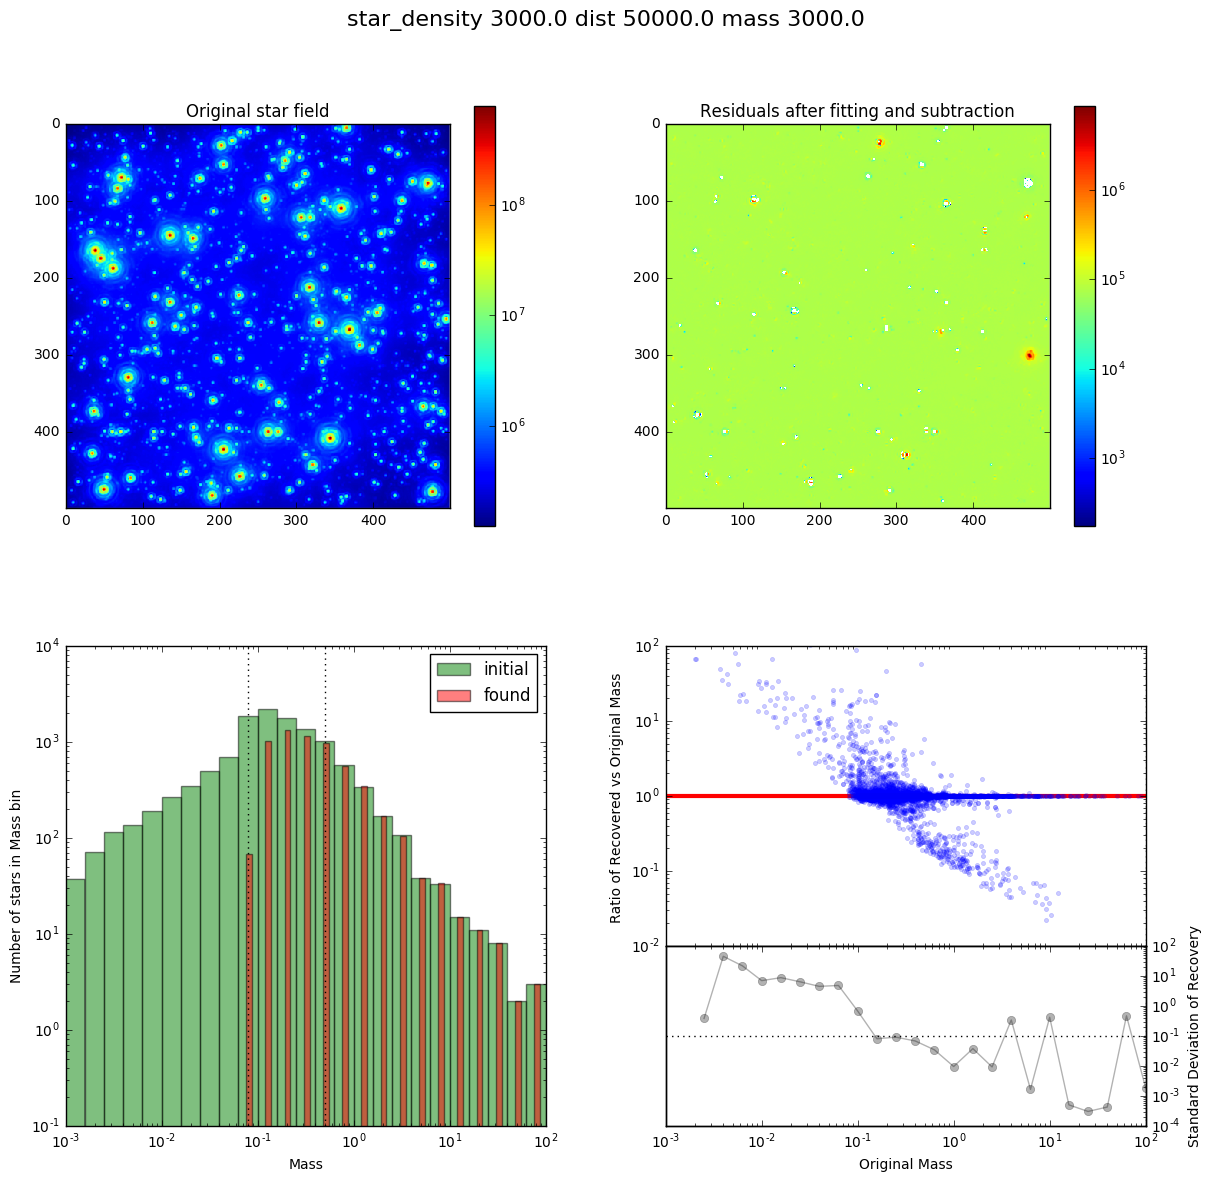

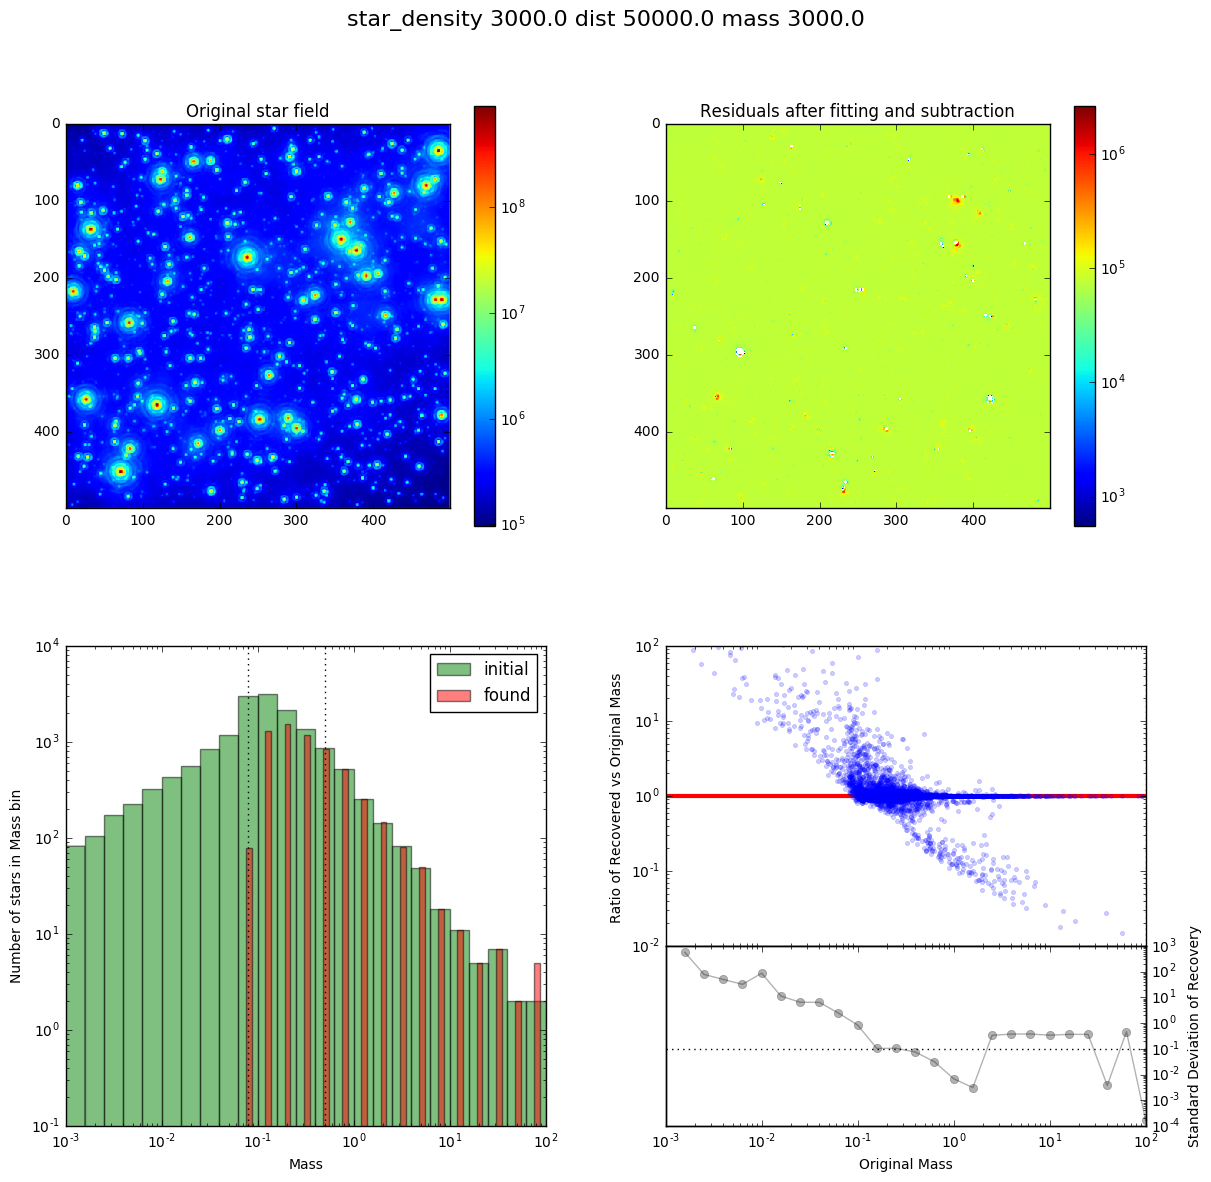

In [10]:
dname = "results_alpha/"

psf_name = "PSF_MAORY_SCAO_Ks_15deg.fits"
psf = fits.getdata(psf_name)

bins = 30
#mass = 6000
lims = [[0.001, 0.08], [0.08, 0.5], [0.5, 300]]
alphas = [0.3, 1.3, 2.3]

exptime = 18000
ndit = 1

m_range = [3E3]
#m_range = np.logspace(2, 6, 17)
#d = np.array([8.5E3, 20E3, 50E3, 200E3, 800E3, 2E6])
#d = np.logspace(4, 6, 9)
d = np.array([50E3])
dist_mods = 5*np.log10(d)-5

iii = 1
alphas_list = [ [0.3, 1+a, 2.3] for a in [0, 0.2, 0.3, 0.4, 0.6, 1]]
scale_factors = [0.3, 1, 1]

#############################################################################
for dist_mod in dist_mods:      # GC=14.5, LMC=18.5, Leo I=21.5, M31=24.5
    for mass in m_range:
        for alphas in alphas_list:
            #try:
                px_fov = 500

                masses = imf.imf_population(mass=mass*8/5, lims=lims, alphas=alphas, scale_factors=scale_factors)
                lums = imf.luminosity_from_mass(masses)
                mags = imf.abs_mag_from_mass(masses) + dist_mod

                radius = 4
                n = len(lums)
                a = px_fov
                im = np.zeros((a, a))
                x,y = np.random.randint(radius, a-radius, (2, n))
                xs = 0.004 * (x - a//2)
                ys = 0.004 * (y - a//2)

                dist = 10**(1 + dist_mod / 5)
                star_density = mass
                print("star_density", star_density, "dist", dist, "mass", mass)
                
                chip_layout = """
                #  id    x_cen    y_cen   x_len   y_len   angle    gain
                #        arcsec   arcsec   pixel  pixel     deg  e-/ADU
                    0        0        0    """ + str(a) + "  " + str(a) + """   0.0     1.0
                """
                
                cmd = sim.UserCommands()
                cmd["OBS_EXPTIME"] = exptime
                cmd["SCOPE_PSF_FILE"] = psf_name
                cmd["INST_FILTER_TC"] = "Ks"
                cmd["FPA_LINEARITY_CURVE"] = "none"
                cmd["FPA_USE_NOISE"] = "no"
                cmd["FPA_CHIP_LAYOUT"] = chip_layout

                opt = sim.OpticalTrain(cmd)
                fpa = sim.Detector(cmd, small_fov=False)

                src = sim.source.stars(mags=mags, x=xs, y=ys)
                src.apply_optical_train(opt, fpa)
                
                hdu = fpa.read_out()
                im = hdu[0].data.T
                for kk in range(1, ndit):
                    hdu = fpa.read_out()
                    im += hdu[0].data.T
                
                #############################################################################

                results, new_im = imf.iter_psf_photometry(im, psf, radius, n_steps=7, e_limit=0.5)
                
                yr, xr = results["xcentroid"], results["ycentroid"]

                found_srcs = SkyCoord(ra=xr*u.arcsec, dec=yr*u.arcsec)  
                init_srcs = SkyCoord(ra=x*u.arcsec, dec=y*u.arcsec)  
                idx, d2d, d3d = match_coordinates_sky(found_srcs, init_srcs)
                matched = np.array([x[idx], xr, y[idx], yr, lums[idx], results["m"]]).T
                names = ["x_orig", "x_match", "y_orig", "y_match", "lum_orig", "lum_match"]

                tbl_matched = Table(data=matched, names=names)

                ######################################################################################    

                n = 26
                bins = np.logspace(-3, 2, n)

                #i = np.where(bins > 1)[0][0]
                #f = np.median(tbl_matched["lum_match"][i:] / tbl_matched["lum_orig"][i:])
                mask = tbl_matched["lum_orig"] > 0.5
                f = theilslopes(tbl_matched["lum_match"][mask], tbl_matched["lum_orig"][mask])[0]

                mass_orig = imf.mass_from_luminosity(tbl_matched["lum_orig"])
                mass_found = imf.mass_from_luminosity(results["m"] / f)
                mass_match = imf.mass_from_luminosity(tbl_matched["lum_match"] / f)
                mass_ratio = mass_match / mass_orig

                results.add_column(Column(data=mass_found, name="mass_found"))
                
                
                tbl_mass = Table(data=[mass_orig, mass_match], names=["mass_orig", "mass_match"])
                tbl_matched = hstack(tbl_matched, tbl_mass)

                tbl_stats = imf.binned_clipped_stats(mass_orig, mass_ratio, bins)

                mask = (tbl_stats["std"] > 0) * (tbl_stats["std"] < 99) * (bins > 1E-2)[1:]
                mass_trusted = np.interp(0.02, tbl_stats["std"][mask], bins[1:][mask])
                
                
                h_orig, be = np.histogram(mass_orig,  bins=bins)
                h_match, be = np.histogram(mass_match,  bins=bins)
                h_found, be = np.histogram(mass_found,  bins=bins)
                tbl_hist = Table(data=[h_orig, h_match, h_found], names=["n_orig", "n_match", "n_found"])

                tbl_stats = hstack([tbl_stats, tbl_hist])

                fname = dname+"tbl_stats_dist="+str(dist)+"_rho="+str(star_density)+"_alphas["+str(int(iii))+"]="+str(alphas[iii])+".dat"
                tbl_stats.write(fname, format="ascii")
                results.write(fname.replace("stats", "found"), format="ascii")

                ##############################################################
                
                #freq_found, bins_found = np.histogram(mass_found, bins=bins)

                #e_fit = []
                #a_fit = []
                #for lim in lims:
                #    mask = (bins_found[1:] > lim[0]) * (bins_found[1:] < lim[1]) * (freq_found > 0)
                #    xlog = np.log10(bins_found[1:])[mask]
                #    ylog = np.log10(freq_found)[mask]

                #    q = linregress(xlog, ylog)
                #    a_fit += [q[0]]
                #    e_fit += [q[4]]
                #    print(1-p, alphas, 1-q[0], q[4])
                    
                #x_fit, y_fit = imf.power_law(a_fit, lims, 0.01, scale_factors)
                #x_fit, y_fit = np.log10(x_fit), np.log10(y_fit)

                ######################################################################################

                q = radius    
                plt.figure(figsize=(12,12))

                ########################################################################


                plt.axes([0.05, 0.55, 0.4, 0.35])

                plt.title("Original star field")
                plt.imshow(im, norm=LogNorm(), interpolation="none")
                plt.colorbar()

                ########################################################################


                plt.axes([0.55, 0.55, 0.4, 0.35])
                plt.title("Residuals after fitting and subtraction")
                plt.imshow(new_im, norm=LogNorm(), interpolation="none")
                plt.colorbar()

                ########################################################################


                plt.axes([0.05, 0.05, 0.4, 0.4])

                plt.hist(masses,  bins=bins, alpha=0.5, label="initial", rwidth=1, color="g")
                plt.hist(mass_found, bins=bins, alpha=0.5, label="found", rwidth=0.3, color="r")
                plt.axvline(0.08, ls=":", c="k")
                plt.axvline(0.5,  ls=":", c="k")
                #plt.text(0.07, 0.9E3, "$\gamma$="+str(-a_fit[0])[:4], 
                #         verticalalignment="top", horizontalalignment="right")
                #plt.text(0.09, 0.9E3, "$\gamma$="+str(-a_fit[1])[:4], 
                #         verticalalignment="top", horizontalalignment="left")
                #plt.text(0.51, 0.9E3, "$\gamma$="+str(-a_fit[2])[:4],
                #         verticalalignment="top", horizontalalignment="left")
                
                
                #plt.axvline(mass_trusted, ls=":", c="k")
                #f = 5
                #plt.plot(10**x_fit, 10**(y_fit + f), "k:")
                
                #plt.hist(mass_match, bins=bins, alpha=0.5, label="matched", rwidth=0.3, color="r")

                #plt.axvline(mass_min, c="k", linestyle=":")
                #plt.axvline(mass_max, c="k", linestyle=":")
                #print(x_max, x_min)

                plt.semilogx()
                plt.yscale('log', nonposy='clip')
                plt.xlabel("Mass")
                plt.ylabel("Number of stars in Mass bin")
                plt.ylim(ymin=1E-1)
                plt.legend(loc=1)

                ########################################################################


                plt.axes([0.55, 0.2, 0.4, 0.25])

                plt.plot(mass_orig, mass_match / mass_orig, ".", alpha=0.2)
                plt.axhline(1, linewidth=3, c="r", zorder=0)
                plt.axvline(mass_trusted, ls=":", c="k")
                plt.loglog()
                plt.ylim(1E-2, 1E2)
                
                #plt.xlabel("Original Mass")
                plt.ylabel("Ratio of Recovered vs Original Mass ")
                plt.xticks([])


                ########################################################################

                plt.axes([0.55, 0.05, 0.4, 0.15])

                plt.xlabel("Original Mass")
                plt.yticks([])
                plt.gca().twinx()
                plt.ylabel("Standard Deviation of Recovery")

                plt.plot(bins[1:], tbl_stats["std"], "ko-", alpha=0.3)
                plt.axhline(0.1, ls=":", c="k")
                plt.axvline(mass_trusted, ls=":", c="k")
                
                plt.loglog()
                #plt.ylim(1E-5, 1E2)

                dist = 10**(1+dist_mod/5)
                                
                ttl = "star_density "+ str(np.round(star_density, 2)) + " dist " +str(dist) + " mass " + str(mass)

                plt.suptitle(ttl, fontsize=16)

                plt.savefig(fname.replace(".dat", ".png"), format="png")
                
            #except:
                
                #print("Being Pissy, pass")
                #pass 

In [9]:
dist_mod

18.494850021680094

# Plot some graphs to show the effect of 1 hour of PSF rotation

In [4]:
exptime_rot = ndit * exptime * 360 * (1*u.s).to(u.day).value

In [18]:
def rotate_blur(image, angle):
    """
    Rotates and coadds an image over a given angle
    
    ..todo:
        Replace the function _rotate_blur in simcado.spatial with this one
    
    """
    
    edge_pixel_angle = (np.arctan2(1, (psf_s.shape[0] // 2))*u.rad).to(u.deg).value

    angles = [angle]
    while angles[-1] > edge_pixel_angle and len(angles) < 25: angles += [angles[-1] / 2.]

    image_rot = np.copy(image)
    for ang in angles: image_rot += spi.rotate(image_rot, ang, reshape=False, order=1)
    
    image_rot /= image_rot.sum()
    
    return image_rot

In [11]:
psf_single = fits.open("./PSF_MAORY_SCAO_Ks_2.fits")[0].data

#psf_s = psf_single[0].data
#psf_rot = rotate_blur(psf_s, exptime_rot)

psf_rot = fits.open("./PSF_MAORY_SCAO_Ks_15deg.fits")[0].data

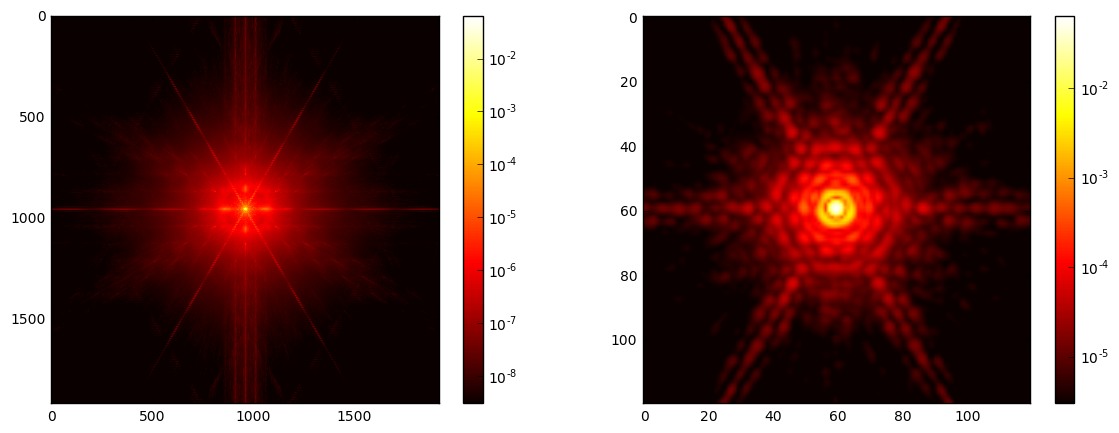

In [16]:
plt.figure(figsize=(14,5))

plt.subplot(121)

plt.imshow(psf_single/psf_single.sum(), norm=LogNorm(), cmap="hot", vmin=3E-9)
plt.colorbar()

plt.subplot(122)

plt.imshow(psf_single[900:1020, 900:1020]/psf_single.sum(), norm=LogNorm(), cmap="hot", vmin=3E-6)
plt.colorbar()


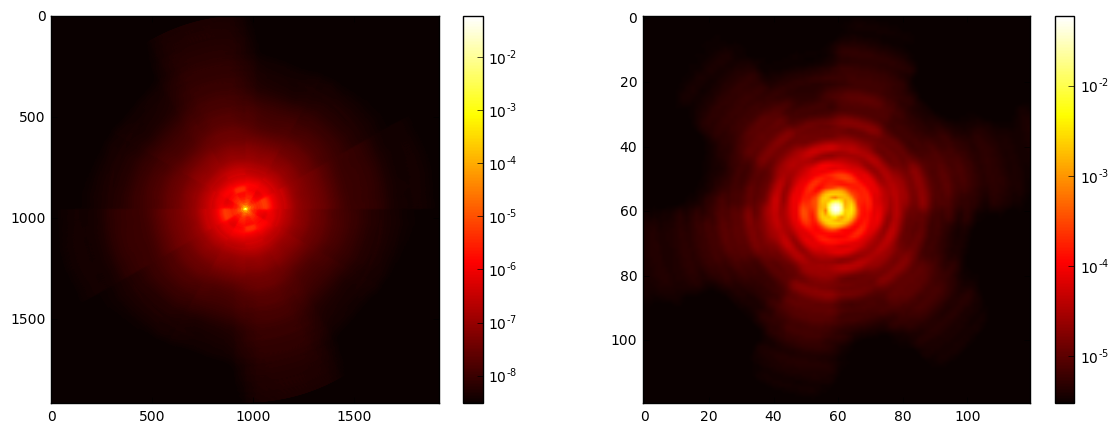

In [17]:
plt.figure(figsize=(14,5))

plt.subplot(121)

plt.imshow(psf_rot, norm=LogNorm(), cmap="hot", vmin=3E-9)
plt.colorbar()

plt.subplot(122)

plt.imshow(psf_rot[900:1020, 900:1020], norm=LogNorm(), cmap="hot", vmin=3E-6)
plt.colorbar()

In [7]:
import poppy

In [8]:
psf_inst = fits.open("PSF_MAORY_SCAO_Ks_2.fits")
psf_inst[0].data /= psf_inst[0].data.sum()
psf_inst[0].header["PIXELSCL"] = psf_inst[0].header["CDELT1"]

psf_blur = fits.open("PSF_MAORY_SCAO_Ks_15deg.fits")
psf_blur[0].data /= psf_blur[0].data.sum()
psf_blur[0].header["PIXELSCL"] = psf_inst[0].header["CDELT1"]

In [9]:
ri, fi = poppy.radial_profile(psf_inst)
rb, fb = poppy.radial_profile(psf_blur)

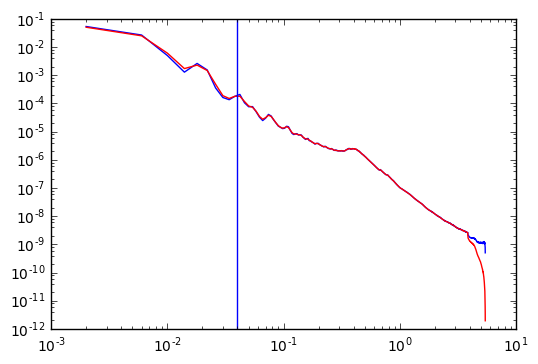

In [11]:
plt.loglog(ri, fi, "b")
plt.loglog(rb, fb, "r")
plt.axvline(0.04)

In [20]:
p = fits.getdata("./PSF_MAORY_SCAO_Ks_2.fits")

In [ ]:
edge_pixel_angle = (np.arctan2(1, (psf_s.shape[0] // 2))*u.rad).to(u.deg).value

angles = [angle]
while angles[-1] > edge_pixel_angle and len(angles) < 25: angles += [angles[-1] / 2.]

image_rot = np.copy(image)
for ang in angles: 
    image_rot += spi.rotate(image_rot, ang, reshape=False, order=1)
    image_rot /= image_rot.sum()
    
    plt.figure()
    plt.imshow()
    
    plt.savefig("rotated_psf_images/ang")
    plt.clf()
    

# Make a graph for the 

[ 2.1095572  -0.86464223] [0.3, 1.3, 2.3] -0.645393237953 0.328671665
[ 2.1095572  -0.86464223] [0.3, 1.3, 2.3] 1.19666265146 0.103423397142
[ 2.1095572  -0.86464223] [0.3, 1.3, 2.3] 2.10955719603 0.0578628301448


[]

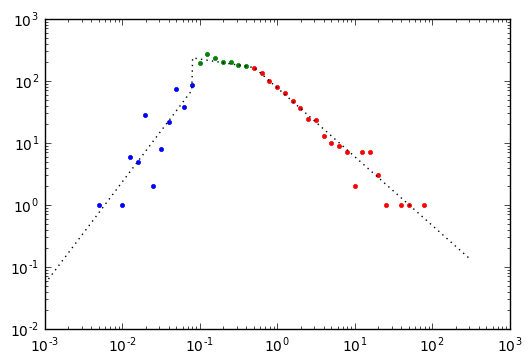

In [35]:
from scipy.stats import linregress

a_fit = []
b_fit = []
for lim in lims:
    mask = (x[1:] > lim[0]) * (x[1:] < lim[1]) * (y > 0)
    xlog = np.log10(x[1:])[mask]
    ylog = np.log10(y)[mask]
    
    q = linregress(xlog, ylog)
    b_fit += [q[0]]
    print(1-p, alphas, 1-q[0], q[4])

    plt.plot(x[1:][mask], y[mask], ".")
    
    
ax, ay = imf.power_law(b_fit, lims, 0.01, scale_factors)
ax, ay = np.log10(ax), np.log10(ay)

f = 4.38
plt.plot(10**ax, 10**(ay + f), "k:")

plt.loglog()

In [8]:
def distance_from_dist_mod(mu):
    """
    d = 10**(1 + mu / 5)
    """
    
    d = 10**(1 + mu / 5)
    return d

def dist_mod_from_distance(d):
    """
    mu = 5 * np.log10(d) - 5
    """
    
    mu = 5 * np.log10(d) - 5
    return mu


def telescope_diffraction_limit(aperture_size, wavelength, distance=None):
    """
    Returns the diffraction limit of a telescope
    
    Parameters
    ----------
    aperture_size : float
        [m] The diameter of the primary mirror
        
    wavelength : float
        [um] The wavelength for diffarction
        
    distance : float, optional
        Default is None. If ``distance`` is given, the transverse distance for
        the diffraction limit is returned in the same units as ``distance``
    
    
    Returns
    -------
    diff_limit : float
        [arcsec] The angular diffraction limit. 
        If distance is not None, diff_limit is in the same units as distance
    
    """
    
    diff_limit = (((wavelength*u.um)/(aperture_size*u.m))*u.rad).to(u.arcsec).value
    
    if distance is not None:
        diff_limit *= distance / u.pc.to(u.AU)
    
    return diff_limit

In [45]:
dist_mod_from_distance(50000), telescope_diffraction_limit(6.5, 1.6, 50000) / telescope_diffraction_limit(38.4, 1.6, 50000)


(18.494850021680094, 5.907692307692308)

In [23]:
tbl = sim.source.get_lum_class_params()

In [31]:
[print(tbl[i].data) for i in range(len(tbl)) if tbl[i]["Mv"] > 8]

('K8V',  0.6,  0.16,  0.95,  3780.,  1.37,  8.3, -1.52,  6.78)
('K9V',  0.5,  0.14,  0.98,  3640.,  1.43,  8.6, -1.74,  6.86)
('M0V',  0.5,  0.13,  0.99,  3500.,  1.49,  9., -1.99,  7.01)
('M1V',  0.5,  0.06,  0.77,  3333.,  1.57,  10.1, -2.33,  7.77)
('M2V',  0.4,  0.03,  0.61,  3167.,  1.65,  11.2, -2.72,  8.48)
('M3V',  0.3,  0.02,  0.51,  3000.,  1.74,  12.3, -3.18,  9.12)
('M4V',  0.3,  0.01,  0.44,  2833.,  1.83,  13.4, -3.71,  9.69)
('M5V',  0.2,  0.01,  0.38,  2667.,  1.93,  14.6, -4.34,  10.26)
('M6V',  0.2,  0.,  0.37,  2500.,  2.03,  15.7, -5.08,  10.62)
('M7V',  0.1,  0.,  0.38,  2333.,  2.14,  16.8, -5.97,  10.83)
('M8V',  0.1,  0.,  0.43,  2167.,  2.26,  17.9, -7.02,  10.88)
('M9V',  0.1,  0.,  0.55,  2000.,  2.39,  19., -8.3,  10.7)


[None, None, None, None, None, None, None, None, None, None, None, None]

In [26]:
tbl.colnames

['Stellar_Type',
 'Mass',
 'Luminosity',
 'Radius',
 'Temp',
 'B-V',
 'Mv',
 'BC(Temp)',
 'Mbol']

In [46]:
10**4.3

19952.62314968879

In [6]:
def transverse_distance(angle, distance):
    """
    Turn an angular distance into a proper transverse distance
    
    Parameters
    ----------
    angle : float
        [arcsec] The on-sky angle
        
    distance : float
        The distance to the object. Units are arbitary
        
    Returns
    -------
    trans_distance : float
        proper transverse distance. Has the same Units as ``distance``
    
    """
    
    trans_distance = angle * distance * u.AU.to(u.pc)
    
    return trans_distance

def angle_in_arcseconds(distance, width):
    """
    Returns the angular distance of an object in arcseconds. Units must be consistent
    """
    
    return np.arctan2(width, distance)*u.rad.to(u.arcsec)
    

In [82]:
#transverse_distance(0.1, 50000), 
2.5 * 10**4.3 / angle_in_arcseconds(8500, 0.4)**2, telescope_diffraction_limit(6.5, 1.0)**-2


(529.42886005723346, 993.0621902768858)

In [84]:
(0.032/0.007)**2

20.897959183673468

In [2]:
lmc_oc = ascii.read("LMC_clusters.csv", data_start=2)

masses = 10**lmc_oc["logM_phot"]
r_core = lmc_oc["r_core"]
r_eff = lmc_oc["r_eff"]
names = lmc_oc["Name"]
dist = lmc_oc["Distance"]
age = lmc_oc["Age"]
mass_lims = lmc_oc["limit_mass"]
gal = lmc_oc["Galaxy"]

Cluster mass:  60255.8056747
Cluster mass:  26301.6085889
Cluster mass:  27542.2696665
Cluster mass:  72443.5823781
Cluster mass:  22907.2639893
Cluster mass:  22908.0869759
Cluster mass:  19952.4966541
Cluster mass:  20417.092904
Cluster mass:  15112.693573
Cluster mass:  10707.9274389
Cluster mass:  17377.68995
Cluster mass:  15478.6617156
Cluster mass:  28182.5679376
Cluster mass:  23988.0806772
Cluster mass:  23988.2978472
Cluster mass:  38016.5215331
Cluster mass:  70778.7024743
Cluster mass:  38903.6414566
Cluster mass:  37153.3784976
Cluster mass:  10229.2958007
Cluster mass:  31621.0015972
Cluster mass:  57543.3694604
Cluster mass:  31607.1834762
Cluster mass:  26915.2792037
Cluster mass:  17782.5180473
Cluster mass:  9999.1313726
Cluster mass:  36307.5186912
Cluster mass:  19951.9795912
Cluster mass:  12589.082427
Cluster mass:  9997.44305774
Cluster mass:  31622.0543803
Cluster mass:  9999.60567944
Cluster mass:  15848.6186405
Cluster mass:  12588.6769373


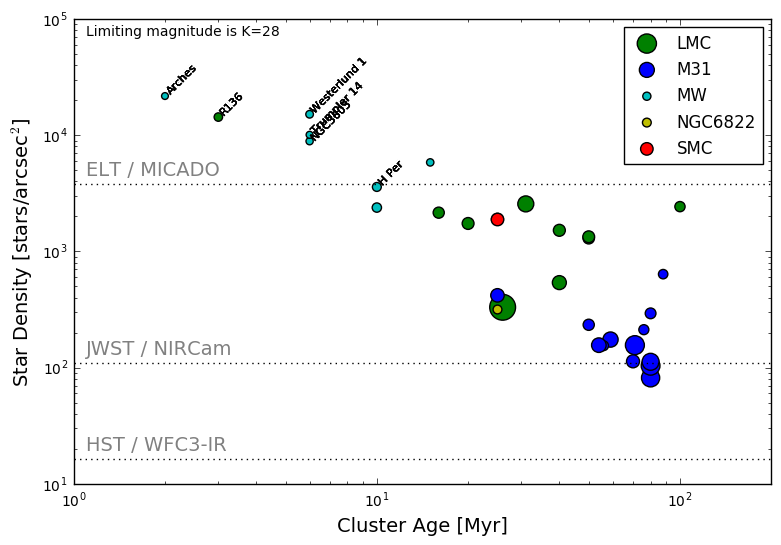

In [21]:
plt.figure(figsize=(9, 6))

n_stars = [np.sum(imf.imf_population(mass) > lim) for mass, lim in zip(masses, mass_lims)]
rho = n_stars / angle_in_arcseconds(50000, r_eff)

leg = []
ud = np.unique(gal)
for i in range(len(ud)):
    mask = gal == ud[i]
    j = np.where(mask)[0][0]
    leg += [plt.scatter(age[mask], rho[mask], c="gbcyrmk"[i], label=gal[j], s=20+r_eff[mask]*10)]   # 
    for i in range(len(age)): 
        if names[i] in ["Arches", "Westerlund 1", "R136", "Trumpler 14", "H Per"]:
            plt.text(age[i], rho[i], names[i], fontsize=8, rotation=45, verticalalignment="bottom", horizontalalignment="left") 

wavelength = 1.2    
for t, ap in zip(["ELT / MICADO", "JWST / NIRCam", "HST / WFC3-IR"], [38, 6.5, 2.5]):
    y = (2.5*telescope_diffraction_limit(ap, wavelength))**-2
    plt.axhline(y, ls=":", c="k")
    plt.text(1.1E0, 1.1*y, t, color="gray", verticalalignment="bottom", fontsize=14)

plt.text(1.1E0, 0.9E5, """Limiting magnitude is K=28""", verticalalignment="top")
# Star densities of clusters respect the magnitude limit
# Resolvability limits assume an are FWHM for $\lambda$=1.2$\mu$m
# Data taken from Portegies Zwart (2010)""")
    
plt.xlabel("Cluster Age [Myr]", fontsize=14)
plt.ylabel("Star Density [stars/arcsec$^2$]", fontsize=14)

plt.loglog()
plt.xlim(1E0, 2E2)
plt.ylim(1E1, 1E5)

plt.legend(scatterpoints=1)

In [226]:
dist_mod_from_distance(3600), np.sum(imf.imf_population(10**4.6) > 0.85) / angle_in_arcseconds(770000, 10)

Cluster mass:  39810.28419


(12.781512503836435, 2951.3614615619613)

In [233]:
telescope_diffraction_limit(2.5, 2.2)

0.1815130294974448

Stellar_Type,Mass,Luminosity,Radius,Temp,B-V,Mv,BC(Temp),Mbol
str6,float64,float64,float64,float64,float64,float64,float64,float64
A0V,2.9,67.4,2.88,9900.0,-0.06,0.6,-0.42,0.18
A1V,2.7,49.2,2.59,9650.0,-0.06,0.9,-0.38,0.52
A2V,2.5,39.4,2.44,9400.0,-0.05,1.1,-0.34,0.76
A3V,2.4,28.9,2.2,9150.0,-0.04,1.4,-0.3,1.1
A4V,2.1,23.2,2.09,8900.0,0.0,1.6,-0.26,1.34
A5V,1.9,17.0,1.89,8650.0,0.05,1.9,-0.23,1.67
A6V,1.8,15.1,1.89,8400.0,0.09,2.0,-0.2,1.8
A7V,1.8,12.2,1.81,8150.0,0.14,2.2,-0.17,2.03
A8V,1.8,10.9,1.81,7900.0,0.19,2.3,-0.14,2.16
